# **text to text genration **
in this task we will create a word based text genration model where model is trained on each word of text to predict the next sequence of words.we can formulate predicted sequence in a very formated way like writing blogs ,chatbot, content creation and many more applications can be created. but here in this task we will simply predict the next sequence of the words based on text that we will feed to our model . we will train a recurnet neural network GRU

# **About Dataset:**
it is a textual data of **"The Lord of the Rings"** series i collacted it from **kaggle** here im providing link for dataset
link:
 " https://www.kaggle.com/datasets/prashantkarwasra/books-dataset-text-generation"
 now before loading dataset we will prepare our working enviornment with some installations and will import some libraries

In [1]:
%%capture
!wget http://example.com/file.zip
import nltk
nltk.download('punkt_tab')
!pip install tensorflow
!pip install keras

!pip install nltk
!pip install keras-tuner -q


In [20]:
import numpy as np
from nltk.tokenize import sent_tokenize
import re
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from tensorflow.keras.layers import Dense,  GRU, Embedding,  Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import itertools
import random
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


now we will upload text files

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Hobbit1.txt to Hobbit1.txt
Saving LOTR1.txt to LOTR1.txt
Saving LOTR2.txt to LOTR2.txt
Saving LOTR3.txt to LOTR3.txt
Saving Silmarillion4.txt to Silmarillion4.txt


these are 5 files we will cobine them as a single file

In [12]:
combined_text = ""


for file_name in uploaded.keys():
    try:

        with open(file_name, 'r') as file:
            file_content = file.read().lower()

            combined_text += file_content + "\n"
    except Exception as e:
        print(f"error reading file {file_name}: {e}")


with open("combined_text.txt", "w") as output_file:
    output_file.write(combined_text)


if combined_text.strip():
    print("files combined successfully  the first 100 chars")
    print(combined_text[:100])
else:
    print("no content found in the combined text")

files combined successfully  the first 100 characters:
chapter i 


an unexpected party 


in a hole in the ground there lived a hobbit. not a nasty, dirty


In [13]:
print(len(combined_text))

3712788


# **text_claeaning and preprocessing**
we can not directly feed textual data to Recurent Neural Network so we will have convert our text to some vector shape for which  we will use word embeddings. to make embedings we have to preprocess data by cleaning data createing sequences of equal length that is padded sequences.so we will move forward step by step
we will use nltk tokenize to convert our text into list of sentences

In [15]:
sentences = nltk.sent_tokenize(combined_text)

now we will remove every thing except English alphabets we have already did lower casing at time of data reading now we will remove all sort of numeric values punctuation trailing white spaces for that we will use regular expresion


In [45]:
cleaned_sentences =[ re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z\s]', '', sentences)).strip()
                for sentences in sentences

                ]
# cleaned_sentences[:10]
print(type(cleaned_sentences))
print(len(cleaned_sentences))

<class 'list'>
43227


now we will split our data into 3 sets training, validation and testing test

In [17]:
division_proportions = (0.7, 0.15, 0.15)
train_size = int(len(cleaned_sentences ) * division_proportions[0])
size_test_val = train_size + int(len(cleaned_sentences ) * division_proportions[1])
train_set = cleaned_sentences [:train_size]
val_set = cleaned_sentences [train_size:size_test_val]
test_set = cleaned_sentences [size_test_val:]
print(f"{train_set[:1]}\ntrain_set_len{len(train_set)}\n val_set_len{len(val_set)}\n test_set_len{len(test_set)}\n{type(train_set)}")

['chapter i an unexpected party in a hole in the ground there lived a hobbit']
train_set_len30258
 val_set_len6484
 test_set_len6485
<class 'list'>


now we will initialise keras tokenizer to get vocabualry word index maping creating text to sequnces

In [21]:
tokenizer = Tokenizer(num_words= 500000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_set)
word_index=(tokenizer.word_index)
num = 5
first_5_word_index = dict(itertools.islice(word_index.items(), num))
index_to_word = (tokenizer.index_word)
first_5_index_to_word = dict(itertools.islice(index_to_word.items(), num))
vocab_size = len(tokenizer.word_index) + 1
print(f"vocab_size:{vocab_size}\nfirst_5_word_index:{first_5_word_index}\nfirst_5_index_to_word:{first_5_index_to_word}")



vocab_size:13599
first_5_word_index:{'<OOV>': 1, 'the': 2, 'and': 3, 'of': 4, 'to': 5}
first_5_index_to_word:{1: '<OOV>', 2: 'the', 3: 'and', 4: 'of', 5: 'to'}


now we will make a function for rest of our preprocessing here we will create text to sequences and will aplly pading for uniform lentgh of input sequences

In [22]:
def preprocessing(textual_data, maxlen=30):
    seq = tokenizer.texts_to_sequences(textual_data)

    maxlen = 30
    paded_seq = pad_sequences(seq, maxlen=maxlen, padding='post')

    x = paded_seq[:, :-1]
    y= paded_seq[:, -1]

    return( seq, paded_seq, x, y)

now we will call function to create input out shape of our data for train and validation set

In [23]:
train_seq, train_paded_seq, x_train , y_train= preprocessing(train_set, maxlen=30)
print(f"x_train.shape:{(x_train.shape)} \ny_train.shape:{y_train.shape}\ntrain_paded_seq.shape:{train_paded_seq.shape}")


x_train.shape:(30258, 29) 
y_train.shape:(30258,)
train_paded_seq.shape:(30258, 30)


In [24]:
val_seq, val_paded_seq, x_val , y_val= preprocessing(val_set, maxlen=30)
print(f"x_val.shape:{(x_val.shape)} \ny_val.shape:{y_val.shape}\nval_paded_seq.shape:{val_paded_seq.shape}")

x_val.shape:(6484, 29) 
y_val.shape:(6484,)
val_paded_seq.shape:(6484, 30)


now we will check class distribution by ploting histogram

(array([682., 265., 130.,  90.,  59.,  43.,  31.,  24.,  20.,  19.]),
 array([    0.,  1353.,  2706.,  4059.,  5412.,  6765.,  8118.,  9471.,
        10824., 12177., 13530.]),
 <BarContainer object of 10 artists>)

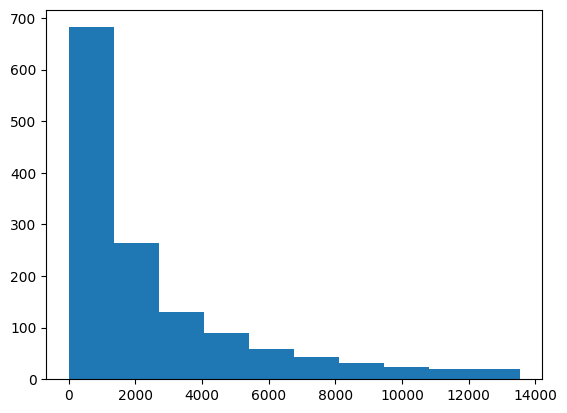

In [48]:
plt.hist(np.unique(y_train))

from histogram right skwed there is a huge difference in class distribution to overcome this situation we will use sklearns class weight function and will simply add class weights in fit function

In [25]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


we have completed preprocessing of data now we will feed our paded sequences to RNN through embeding layer
now we will define a search a space for hyperperameters tuning for this we will use keras tuner

In [26]:
def build_model(hp):
  maxlen=30
  model = keras.Sequential([


      layers.Embedding(input_dim=vocab_size,
                       output_dim=hp.Int("output_dim", min_value=25, max_value=75),
                       input_length=maxlen - 1, input_shape=(maxlen - 1,)),


      layers.GRU(units=hp.Int("units", min_value=32, max_value=128),
                 kernel_regularizer=l2(0.01),return_sequences=False),
      layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.1,
                                   max_value=0.3, step=0.1)),



      layers.Dense(units=vocab_size, activation= "softmax"),



      ])
  optimizer = keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]))
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

now we will confirm status of our search space

In [27]:
build_model(keras_tuner.HyperParameters())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Sequential name=sequential, built=True>

now we will initialise tuner with random search

In [30]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',

    executions_per_trial=1,
    directory='my_dir',
    project_name='text_generation_hyp_tuning_weights_bigspace',
    max_trials=3)

In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 25, 'max_value': 75, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}


we are searching for embeding dim GRU units dropout rate learning rate now we will start start searching

In [31]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
tuner.search(x_train, y_train, epochs=20,batch_size=32 ,
             validation_data=(x_val, y_val),
             callbacks=[early_stopping], verbose=0,
             class_weight=class_weights_dict)

tuner tried differnt combinations of these hyperperamters now we will retrieve some of them and will use best hyperperametrs among them to build our final model

In [32]:
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]
best_hps.values

{'output_dim': 46, 'units': 36, 'dropout_rate': 0.1, 'learning_rate': 0.001}

these are best hypperameters suited to our model based on our data now we will use these to build final model

In [33]:
final_model = build_model(best_hps)

In [34]:
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 29, 46)              │         625,554 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 36)                  │           9,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13599)               │         503,163 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,137,789 (4.34 MB)

 Trainable params: 1,137,789 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

fully connected layers embeding layer which will be feed up with paded sequences of maxlen -1 will output dense vector which will be input of GRU output shape is the size of vocabulary that are our target classes.
now we will train our model with a larger number of epochos we will use early stoping function which will stop training when our model stop learning genrelising sequences and will start momorizing patterens

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history_rnn = final_model.fit(x_train, y_train, validation_data=( x_val, y_val),
                              batch_size=32, epochs=100,
                              callbacks=[early_stopping], verbose=0,
                              class_weight=class_weights_dict)

now we will check total epochos our model run

In [37]:
# Check the total number of epochs the model ran
total_epochs = len(history_rnn.epoch)
print(f"total number of epochs run: {total_epochs}")

total number of epochs run: 93


now we will plot training history accuracy and loss

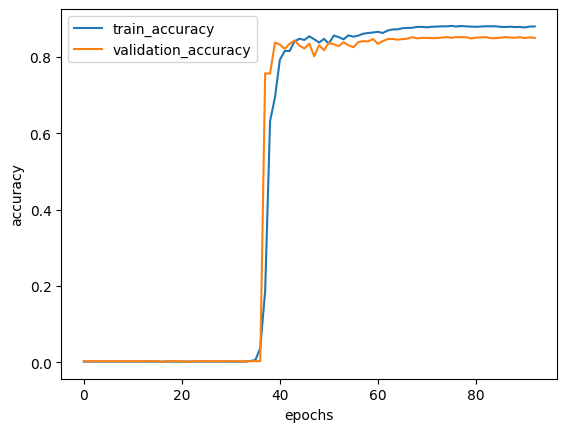

In [38]:
plt.plot(history_rnn.history['accuracy'], label='train_accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='validation_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

from above plot we can observe training and validation accuracy gradualy increases after 35 epochops and stablizes around 80% . accuracy trend of validation and training almost follows same patterens

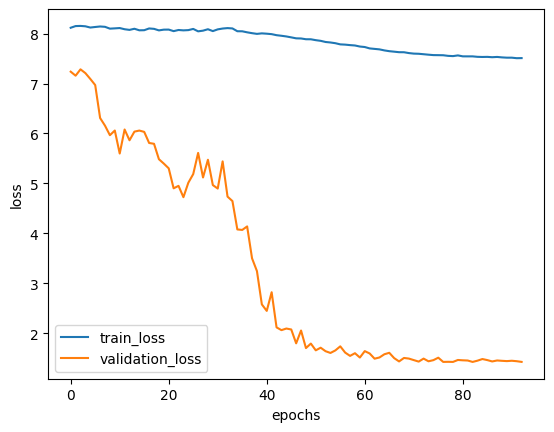

In [39]:
plt.plot(history_rnn.history['loss'], label='train_loss')
plt.plot(history_rnn.history['val_loss'], label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

train loss with a slight decrease remains almost same all over training indicates that there is a room for improvements validation loss decreases sharply and stablizes around 2 indicates our model perfomed well
now we will evaluate our model with validation data by calculating loss accuracy and perplexity metrixs

In [44]:
val_loss, val_accuracy = final_model.evaluate(x_val, y_val,batch_size=32, verbose=0)
val_perplexity = np.exp(val_loss)


print(f"val_loss: {val_loss}")
print(f"val_accuracy: {val_accuracy}")
print(f"val_perplexity: {val_perplexity}")

val_loss: 1.4254403114318848
val_accuracy: 0.8499383330345154
val_perplexity: 4.15968899820608


these metrix aligns with our plots indicating a lower loss that our model predicted well with validation data almost 85% accuracy lower perplexity metrix indicates that our model learned well
now we will preprocess our test data

In [41]:
test_seq, test_paded_seq, x_test , y_test= preprocessing(test_set, maxlen=30)
print(f"x_test.shape:{(x_test.shape)} \ny_test.shape:{y_test.shape}\ntest_paded_seq.shape:{test_paded_seq.shape}")
# print(type(x_train))

x_test.shape:(6485, 29) 
y_test.shape:(6485,)
test_paded_seq.shape:(6485, 30)


now we will get predictions and will show randomly some genrated text against seed text we will randomly select seed dentnce from our test set and will get predictions
we will randomly select seed sentence preprocess it to feed to medl and check created text

In [43]:
random_indices = random.sample(range(len(test_set)), 3)
random_sentences = [test_set[i] for i in random_indices]


for sentence in random_sentences:

    seq = tokenizer.texts_to_sequences([sentence])
    padded_seq = pad_sequences(seq, maxlen=30, padding='post')
    input_seq = padded_seq[:, :-1]


    generated_sentence = []
    for _ in range(20):
        predicted_probs = final_model.predict(input_seq, verbose=0)
        predicted_index = np.argmax(predicted_probs[0])
        predicted_word = index_to_word.get(predicted_index, "<unknown>")

        if predicted_word == "<unknown>" or predicted_word in [".", "!", "?"]:
            break

        generated_sentence.append(predicted_word)


        input_seq = np.roll(input_seq, -1, axis=1)
        input_seq[0, -1] = predicted_index


    print(f"Seed Sentence: {sentence}")
    print(f"Generated Sentence: {' '.join(generated_sentence)}")
    print("-" * 50)

Seed Sentence: the golden hall was arrayed with fair hangings and it was filled with light and there was held the highest feast that it had known since the days of its building
Generated Sentence: him them it them it it them it them them it it it it it it them it it it
--------------------------------------------------
Seed Sentence: there he delved anew his vast vaults and dungeons and above their gates he reared the threefold peaks of thangorodrim and a great reek of dark smoke was ever wreathed about them
Generated Sentence: them them them them them them them them it it it them them them them it it it it them
--------------------------------------------------
Seed Sentence: then slowly a change came over the land and the hearts of the elffriends were sorely troubled and many fell away out of fear and although those that remained still called themselves the faithful their enemies named them rebels
Generated Sentence: them them them them them them them it them them them them them it t

well our model starts genrating text but it dont make any sense repeted words indicates that there is lot of room for improvements
now we will evalute models performance with test set

In [42]:
test_loss, test_accuracy = final_model.evaluate(x_test, y_test,batch_size=32, verbose=0)
test_perplexity = np.exp(val_loss)


print(f"test_loss: {val_loss}")
print(f"test_accuracy: {val_accuracy}")
print(f"test_perplexity: {val_perplexity}")

test_loss: 1.4254405498504639
test_accuracy: 0.8499383330345154
test_perplexity: 4.159689989953338


on unseen data these metrix values indicates that our model perfomed well learned well genrelizing sequences and pattrens

we started from scratch to build an RNN pipeline it perfomed well but still there is a lot we can do to iprove perfomance of our model by adding more layers fine tune by  changing number of units changing dropout rate and learing rate we can use pretrained word embeddings .
we can use pretrained models fo feature extraction then feed to our model or we can use some pretrained model like T5 to enhance progress of our model   